In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


In [ ]:
import numpy as np
import pandas as pd
import datetime
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import os
import utils.time_series_processing as tsp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


## Prepare dataset

In [ ]:
TICKER = "GOTO"
SEQ_LEN = 60
PRED_HORIZON = 22
VAL_SPLIT = 0.2
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
df = pd.read_csv(
    f"./data/{TICKER}/data_integrasi_{TICKER}.csv",
    index_col=0,
    parse_dates=[0],
    date_format="%Y-%m-%d"
    )
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,338.0,354.0,334.0,354.0,840928300,0.086957
2022-07-12,330.0,338.0,330.0,338.0,802215500,0.127820
2022-07-13,324.0,330.0,320.0,330.0,870421000,-0.022727
2022-07-14,332.0,336.0,320.0,324.0,786358600,-0.090032
2022-07-15,320.0,336.0,320.0,332.0,998698500,-0.024390
...,...,...,...,...,...,...
2025-07-25,58.0,59.0,57.0,59.0,5090425000,-0.165906
2025-07-28,59.0,60.0,58.0,58.0,3567335000,-0.139048
2025-07-29,59.0,60.0,58.0,59.0,1423009300,-0.040984


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2022-07-11 to 2025-07-31
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           732 non-null    float64
 1   High            732 non-null    float64
 2   Low             732 non-null    float64
 3   Open            732 non-null    float64
 4   Volume          732 non-null    int64  
 5   nilai_sentimen  732 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 40.0 KB


In [ ]:
df = df.sort_index()
df.index = pd.to_datetime(df.index)
df

,Close,High,Low,Open,Volume,nilai_sentimen
tanggal,,,,,,
2022-07-11,338.0,354.0,334.0,354.0,840928300,0.086957
2022-07-12,330.0,338.0,330.0,338.0,802215500,0.127820
2022-07-13,324.0,330.0,320.0,330.0,870421000,-0.022727
2022-07-14,332.0,336.0,320.0,324.0,786358600,-0.090032
2022-07-15,320.0,336.0,320.0,332.0,998698500,-0.024390
...,...,...,...,...,...,...
2025-07-25,58.0,59.0,57.0,59.0,5090425000,-0.165906
2025-07-28,59.0,60.0,58.0,58.0,3567335000,-0.139048
2025-07-29,59.0,60.0,58.0,59.0,1423009300,-0.040984


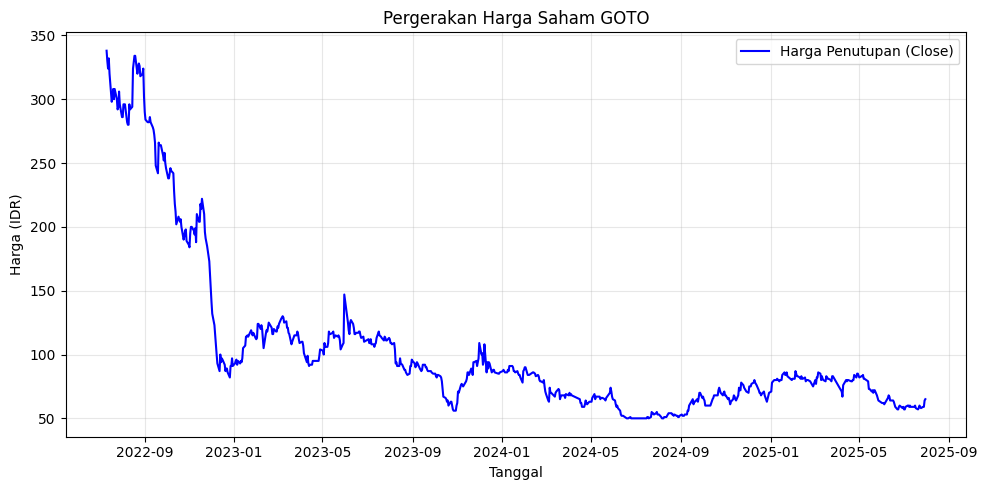

In [ ]:
vs.plot_data(df, TICKER)

In [ ]:
df = df[["Close", "Volume", "nilai_sentimen"]]
df

,Close,Volume,nilai_sentimen
tanggal,,,
2022-07-11,338.0,840928300,0.086957
2022-07-12,330.0,802215500,0.127820
2022-07-13,324.0,870421000,-0.022727
2022-07-14,332.0,786358600,-0.090032
2022-07-15,320.0,998698500,-0.024390
...,...,...,...
2025-07-25,58.0,5090425000,-0.165906
2025-07-28,59.0,3567335000,-0.139048
2025-07-29,59.0,1423009300,-0.040984


In [ ]:
scaler, data_scaled, X_all, y_all, X_train, y_train, X_val, y_val, train_dates, val_dates = tsp.prepare_data_time_series(df)

In [ ]:
print("Train samples:", X_train.shape[0], "val samples:", X_val.shape[0])

Train samples: 520 val samples: 131


In [ ]:
last_date = df.index[-1]
future_dates = pd.bdate_range(start=last_date + datetime.timedelta(days=1), periods=PRED_HORIZON)
#future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=PRED_HORIZON, freq='B')
last_seq = data_scaled[-SEQ_LEN:]

## Ensemble

In [ ]:
lstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_lstm_model.keras")
bilstm_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_bilstm_model.keras")
gru_model = tf.keras.models.load_model(f"./model/{TICKER}/sentimen_gru_model.keras")

In [ ]:
model_names = ["LSTM", "BiLSTM", "GRU"]
models = [lstm_model, bilstm_model, gru_model]

In [ ]:
individual_predictions_train = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_train)
    individual_predictions_train[name] = pred

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
print(individual_predictions_train.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
print(individual_predictions_train)

{'LSTM': array([[0.6547125 , 0.6370065 , 0.6228302 , ..., 0.4791942 , 0.48028904,
        0.4810481 ],
       [0.64291173, 0.625529  , 0.61178267, ..., 0.4718573 , 0.47304648,
        0.4745649 ],
       [0.6308054 , 0.61479974, 0.601515  , ..., 0.46594262, 0.46820375,
        0.4706471 ],
       ...,
       [0.07080179, 0.07044857, 0.06997852, ..., 0.07412304, 0.07322758,
        0.06923996],
       [0.07453884, 0.07474029, 0.07428185, ..., 0.07555215, 0.07576302,
        0.07251302],
       [0.07761396, 0.07828906, 0.0778183 , ..., 0.07736804, 0.07852018,
        0.07568397]], dtype=float32), 'BiLSTM': array([[0.56622744, 0.5699008 , 0.5429967 , ..., 0.42559505, 0.43106908,
        0.41202462],
       [0.5576498 , 0.5599219 , 0.5309564 , ..., 0.4339694 , 0.43941185,
        0.4177532 ],
       [0.54999876, 0.55217373, 0.52291584, ..., 0.43676054, 0.44227666,
        0.41954163],
       ...,
       [0.05940094, 0.06580172, 0.06629354, ..., 0.0625474 , 0.06423602,
        0.06660457],


In [ ]:
individual_predictions_val = {}

for name, model in zip(model_names, models):
    pred = model.predict(X_val)
    individual_predictions_val[name] = pred

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
print(individual_predictions_val.keys())

dict_keys(['LSTM', 'BiLSTM', 'GRU'])


In [ ]:
train_preds = list(individual_predictions_train.values())
val_preds = list(individual_predictions_val.values())

X_stack_train = np.stack(train_preds, axis=2)
X_stack_train = X_stack_train.reshape(X_stack_train.shape[0], -1)
X_stack_val = np.stack(val_preds, axis=2)
X_stack_val = X_stack_val.reshape(X_stack_val.shape[0], -1)

In [ ]:
print(train_preds[1])

[[0.56622744 0.5699008  0.5429967  ... 0.42559505 0.43106908 0.41202462]
 [0.5576498  0.5599219  0.5309564  ... 0.4339694  0.43941185 0.4177532 ]
 [0.54999876 0.55217373 0.52291584 ... 0.43676054 0.44227666 0.41954163]
 ...
 [0.05940094 0.06580172 0.06629354 ... 0.0625474  0.06423602 0.06660457]
 [0.06575166 0.07364241 0.0731016  ... 0.06917828 0.07321764 0.07458135]
 [0.06722198 0.07506779 0.07455065 ... 0.07004079 0.07462154 0.07581823]]


In [ ]:
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(22, activation='linear', input_shape=(66,))
])

meta_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping based on validation loss
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = meta_model.fit(
    X_stack_train, y_train,
    validation_data=(X_stack_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0787 - mae: 0.1694 - val_loss: 0.0064 - val_mae: 0.0542
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - mae: 0.0844 - val_loss: 0.0019 - val_mae: 0.0304
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - mae: 0.0483 - val_loss: 9.6813e-04 - val_mae: 0.0245
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0370 - val_loss: 8.1049e-04 - val_mae: 0.0227
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 7.5089e-04 - val_mae: 0.0215
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0312 - val_loss: 7.2081e-04 - val_mae: 0.0209
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mae: 0.0303 - val_loss: 6.9360e-04 - val_mae: 0.0205
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0297 - val_loss: 6.6658e-04 - val_mae: 0.0201
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

In [ ]:
# prediksi menggunakan meta model
ensemble_preds_hist_train = meta_model.predict(X_stack_train)
ensemble_preds_hist_val = meta_model.predict(X_stack_val)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
future_predictions_base = tsp.predict_ensemble(
    models, scaler, last_seq, meta_model)

print(future_predictions_base[0])

[60.54244506 57.84940797 58.15402484 58.72764152 57.99350858 56.61963499
 58.03387153 57.78122461 55.94326234 56.90746015 54.87438273 60.17609072
 61.96770012 57.10508585 56.6806488  57.25663871 58.98541898 54.82665497
 57.52012122 57.89235497 59.18242455 56.57588708]


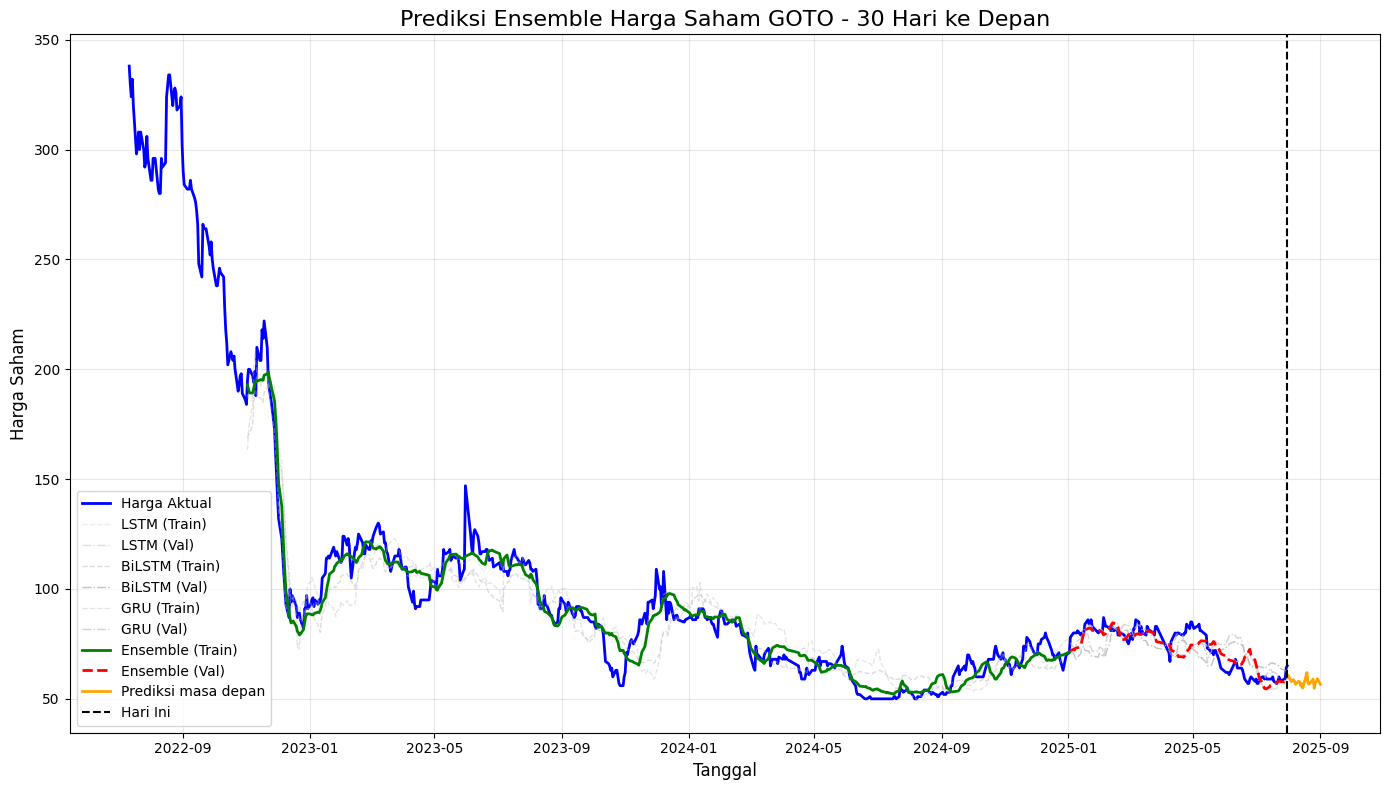

In [ ]:
vs.plot_ensemble_predictions(
    df, scaler, train_dates, val_dates, individual_predictions_train,
    individual_predictions_val, ensemble_preds_hist_train, ensemble_preds_hist_val,
    future_dates, future_predictions_base[0], TICKER
)

In [ ]:
# Menampilkan hasil prediksi masa depan dalam bentuk DataFrame
df_prediksi_masa_depan = pd.DataFrame({
    'Tanggal': future_dates,
    'Prediksi Harga': future_predictions_base[0].flatten()
})
df_prediksi_masa_depan.set_index('Tanggal', inplace=True)
df_prediksi_masa_depan


,Prediksi Harga
Tanggal,
2025-08-01,60.542445
2025-08-04,57.849408
2025-08-05,58.154025
2025-08-06,58.727642
2025-08-07,57.993509
2025-08-08,56.619635
2025-08-11,58.033872
2025-08-12,57.781225
2025-08-13,55.943262


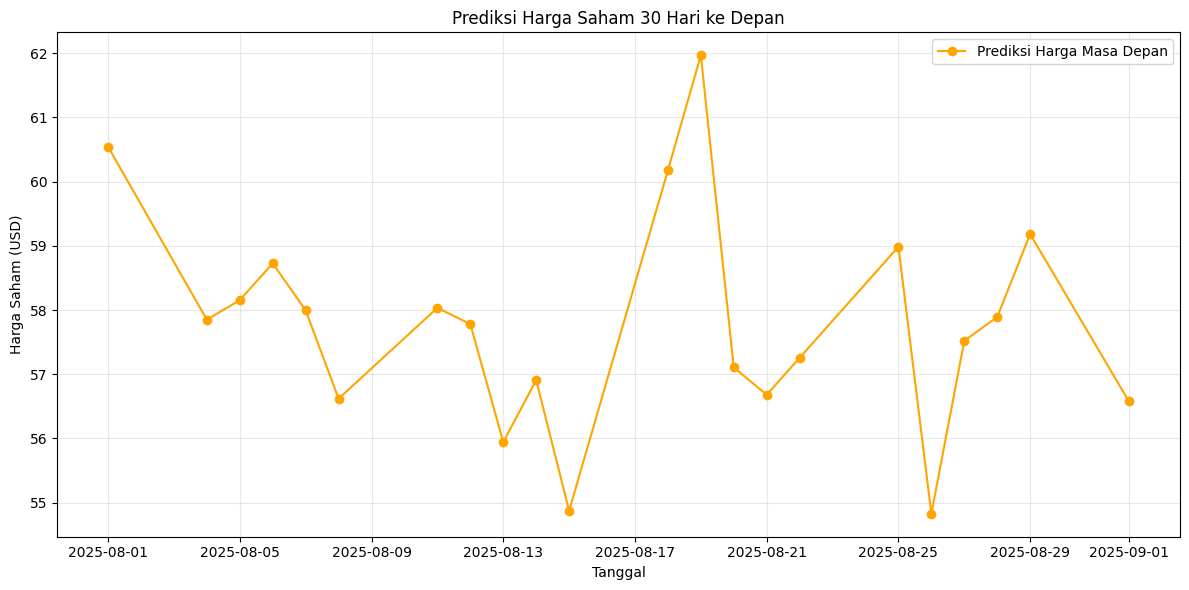

In [ ]:
vs.plot_future_predictions(future_dates, future_predictions_base[0])

In [ ]:
print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val, ensemble_preds_hist_val)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 0.0135
MAPE : 19.9542%
MSE  : 0.0003
RMSE : 0.0170
R2   : 0.7017


In [ ]:
y_val_inv = inverse_scaler(y_val)
ensemble_preds_hist_val_inv = inverse_scaler(ensemble_preds_hist_val)

print(f"Evaluasi hasil prediksi pada Data Validasi:")
tsp.model_evaluate(y_val_inv, ensemble_preds_hist_val_inv)

Evaluasi hasil prediksi pada Data Validasi:
MAE  : 3.8895
MAPE : 5.3066%
MSE  : 24.1065
RMSE : 4.9098
R2   : 0.7028


In [ ]:
meta_model.save(f"./model/{TICKER}/meta_model.keras")
meta_model.save(f"./model/{TICKER}/meta_model.h5")